In [29]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

df = pd.read_csv('Image_classification_data/data_labels_mainData.csv')

In [14]:
df.shape

(9896, 6)

In [15]:
df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [16]:
df.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

In [17]:
cancerous = df[df.isCancerous == 1]
benign = df[df.isCancerous == 0]
cancerous.shape

(4079, 6)

In [18]:
benign.shape

(5817, 6)

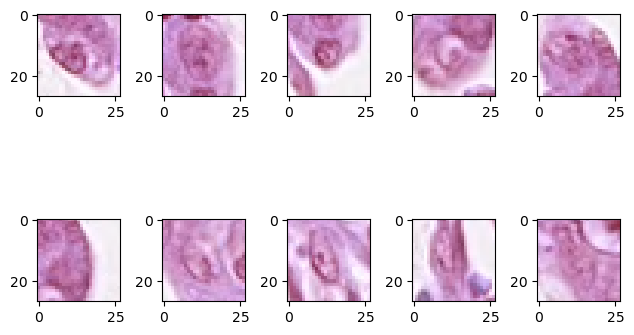

In [41]:
for i in range(10):
    img = cv2.imread(r'Image_classification_data/patch_images/' + cancerous['ImageName'].iloc[i])
    plt.subplot(2,5,i+1)
    plt.imshow(img)
plt.tight_layout()

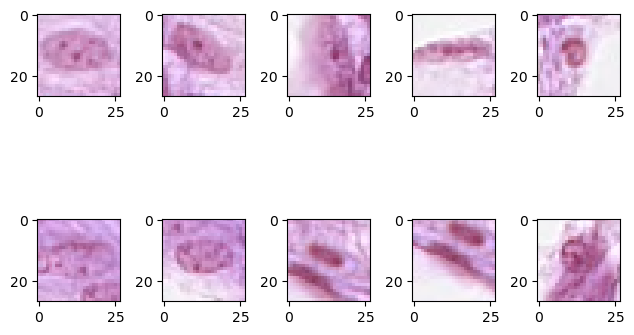

In [42]:
for i in range(10):
    img = cv2.imread(r'Image_classification_data/patch_images/' + benign['ImageName'].iloc[i])
    plt.subplot(2,5,i+1)
    plt.imshow(img)
plt.tight_layout()
# plt.title("Cancerous cell Images")